## LIME ON IMAGE

Step 1 - Read and pre-process image
The image is resized, displayed and pre-processed for Inception V3. The variable 'Xi' contains the image. 

In [48]:
import skimage.io 
import skimage.segmentation

Image to be read


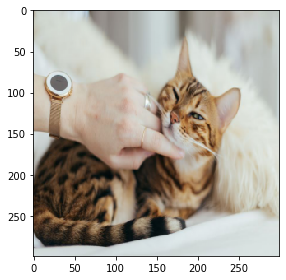

In [2]:
print("Image to be read")
Xi = skimage.io.imread("https://www.data-imaginist.com/assets/images/kitten.jpg") #link for image to be read
Xi = skimage.transform.resize(Xi, (299,299)) # resizing image
skimage.io.imshow(Xi)# Show image 
Xi = (Xi - 0.5)*2 #Inception pre-processing of image

Step 2 - InceptionV3 initialization

The pre-trained InceptionV3 model is available in Keras, which is a widely-used image recognition model and has been shown to have more than 78.1% accuracy on the ImageNet dataset.

In [3]:
import keras

Using TensorFlow backend.


In [4]:
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

Step 3 - Predict class of input image using Inception V3 model.

In [5]:
import numpy as np
from keras.applications.imagenet_utils import decode_predictions

In [37]:
print("The top 5 classes of predictions are - ")
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:]) #np.newaxis is used to increase the dimension of the existing array by one. Here,Input should be 4D
print(decode_predictions(preds)) #top = 5 by default

The top 5 classes of predictions are - 
[[('n02124075', 'Egyptian_cat', 0.46517527), ('n02123045', 'tabby', 0.19108842), ('n02123159', 'tiger_cat', 0.15482591), ('n02127052', 'lynx', 0.043455016), ('n04553703', 'washbasin', 0.0033444196)]]


(1, 1000)

The description of these classes is shown and it can be seen that the "Egyptian cat" is the top class for the given image with the max probability of 0.465.

In [38]:
preds.shape

(1, 1000)

The predicted output(preds) is a vector of 1000 proabilities for each class available in Inception V3. 

In [25]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
print("The indices of the top 5 classes ")
top_pred_classes               

The indices of the top 5 classes 


array([285, 281, 282, 287, 896])

Step 4 - Extract super-pixels from image

In [8]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2) #the higher the kernel size,max_dist, the fewer are the clusters
#Segments image using quickshift clustering
num_superpixels = np.unique(superpixels).shape[0]
print("The number of super pixels generated")
num_superpixels

The number of super pixels generated


66

The generated superpixels are shown in the image below using mark_boundaries.

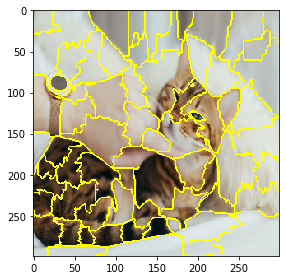

In [9]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

Step 5 - Random perturbations

In [32]:
np.random.seed(222)
num_perturb = 150 
#150 perturbations
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))# The size corresponds to the (no. of perturbations x no. of superpixels) in the image.
print(" Here, '1' represent ON(active) superpixel and '0' represents OFF.")
perturbations[0]

 Here, '1' represent ON(active) superpixel and '0' represents OFF.


array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [11]:
import copy

In [33]:
def perturb_image(img,perturbation,segments): #takes in the parameters : raw image, perturbation vector and superpixels generated
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image #returns the perturbed image

The perturbed image


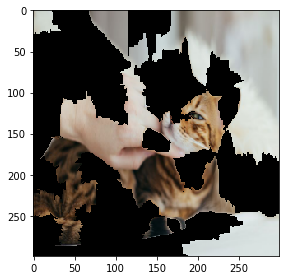

In [34]:
print("The perturbed image")
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels)) 

Step 6 - Predict classes of new generated images 

In [40]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)

Step 7 - Compute distances between the original image and each of the perturbed images.

In [16]:
import sklearn.metrics

In [43]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
#The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()#ravel() function is used to create a contiguous flattened array.
#distances

Step 8 - Compute weights (importance) of each perturbed image using kernel.
The distances are then mapped to a value between zero and one (weight). 

In [44]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

Step 9 - Use 'perturbations', 'predictions' and 'weights' to fit an explainable (linear) model

In [45]:
from sklearn.linear_model import LinearRegression

In [47]:
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,top_pred_classes[0]], sample_weight=weights) # the top predicted class is to be explained
coeff = simpler_model.coef_[0] 
coeff.shape # Each coefficient in the linear model corresponds to one superpixel in the segmented image.

(66,)

Step 10 - Compute top features (superpixels)

In [22]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
#Now we need to sort the coefficients to figure out which are the superpixels that have larger coefficients (magnitude) for the prediction of egyptian cat. 
top_features

array([43, 35, 24, 29])

The superpixels of the top 4 features are shown.

Last Step - Show image with top features

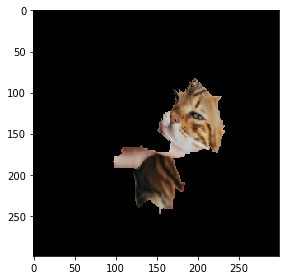

In [23]:
mask = np.zeros(num_superpixels) #The less relevant pixels are black and only the top superpixels are activated.
mask[top_features]= True 
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

Conclusion -

This is the area of the image that produced the prediction of Egyptian cat. 